In [1]:
import sys
sys.path.append('./QCNN_inference_pyc.zip')
from QCNN_inference import qcnn_circuit, load_breastmnist_data

[123. 115. 119. 127. 119. 111. 118. 125. 110.  97.  93. 108.  92.  86.
 100. 104.  81.  77.  74. 121. 113.  96. 113. 128.  72.  68.  60.  76.
 100. 102.  93.  73.  90.  79.  61.  65.  79.  87.  90.  76. 106. 108.
  88.  96. 112. 112.  99.  95.  67.  82.  91. 112. 131. 130. 118. 108.
  50.  57.  76.  89. 109. 108. 102.  90.]


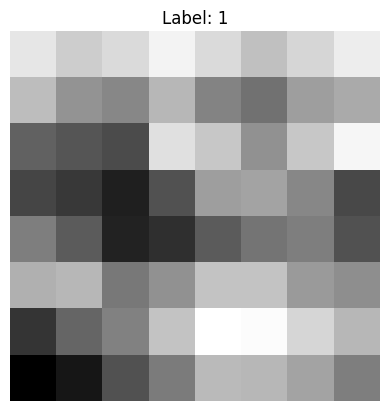

In [2]:
# Load a small sample of BreastMNIST images (resized to 8×8)
# Fetches 10 training and 10 test images
x_train, y_train, x_test, y_test = load_breastmnist_data(num_train=10, num_test=10)

# Select a single example for visualization and encoding
features_sample = x_train[0]
print(features_sample)
label = y_train[0]

# Show the original image
import matplotlib.pyplot as plt
plt.imshow(features_sample.reshape(8, 8),cmap='gray')
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.transpiler.exceptions import CircuitTooWideForTarget # Import the specific error

# ===================================================================
# Part 1: Helper Functions
# ===================================================================

def create_encoder(features, encoding_method='FRQI'):
    # (This function remains the same as the previous version)
    num_pixels = len(features)
    if encoding_method == 'FRQI':
        num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
        num_qubits = num_pos_qubits + 1
        qc = QuantumCircuit(num_qubits)
        color_qubit, pos_qubits = 0, list(range(1, num_qubits))
        angles = (features / 255.0) * (np.pi / 2)
        qc.h(pos_qubits)
        for i, angle in enumerate(angles):
            if np.isclose(angle, 0): continue
            control_state = format(i, f'0{num_pos_qubits}b')
            for j, bit in enumerate(reversed(control_state)):
                if bit == '0': qc.x(pos_qubits[j])
            mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
            qc.append(mcr_gate, pos_qubits + [color_qubit])
            for j, bit in enumerate(reversed(control_state)):
                if bit == '0': qc.x(pos_qubits[j])
        return qc
    elif encoding_method == 'Angle':
        qc = QuantumCircuit(num_pixels)
        angles = (features / 255.0) * np.pi
        for i, angle in enumerate(angles):
            qc.ry(angle, i)
        return qc
    elif encoding_method == 'Amplitude':
        num_qubits = int(np.ceil(np.log2(num_pixels)))
        qc = QuantumCircuit(num_qubits)
        norm = np.linalg.norm(features)
        if np.isclose(norm, 0): features[0] = 1e-9
        amplitudes = features / np.linalg.norm(features)
        qc.initialize(amplitudes, range(num_qubits))
        return qc
    elif encoding_method == 'NEQR':
        color_bits = 8  
        num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
        num_qubits = num_pos_qubits + color_bits
        qc = QuantumCircuit(num_qubits)
        color_qubits = list(range(color_bits)) 
        position_qubits = list(range(color_bits, num_qubits)) 
        qc.h(position_qubits)
        for i, pixel_value in enumerate(features):
            if pixel_value == 0:
                continue
            binary_repr = format(pixel_value, f'0{color_bits}b')
            control_state = format(i, f'0{num_pos_qubits}b')
            for j, bit in enumerate(reversed(control_state)):
                if bit == '0':
                    qc.x(position_qubits[j])
            for color_idx, bit in enumerate(reversed(binary_repr)):
                if bit == '1':
                    control_qubits = position_qubits
                    target_qubit = color_qubits[color_idx]
                    mc_x = XGate().control(num_pos_qubits)
                    qc.append(mc_x, control_qubits + [target_qubit])
            for j, bit in enumerate(reversed(control_state)):
                if bit == '0':
                    qc.x(position_qubits[j])
    
        return qc
    else:
        raise ValueError("Invalid encoding method")

def add_qcnn_layers(qc):
    # (This function remains the same)
    num_qubits = qc.num_qubits
    if num_qubits < 2: return
    for i in range(0, num_qubits - 1, 2):
        qc.cx(i, i + 1)
        qc.rz(np.random.rand(), i)
        qc.ry(np.random.rand(), i + 1)
    if num_qubits > 4:
        for i in range(num_qubits // 2, num_qubits - 1, 2):
            qc.cz(i, i + 1)

def build_and_analyze_circuit(image_size, encoding_method):
    """Builds the pipeline and gracefully handles circuits that are too large."""
    print(f"Analyzing {encoding_method} for {image_size}x{image_size} image...")
    num_pixels = image_size * image_size
    features = np.random.randint(1, 256, num_pixels)
    
    qc = create_encoder(features, encoding_method)
    add_qcnn_layers(qc)
    
    # --- THE FIX IS HERE: Use a try...except block ---
    try:
        backend = AerSimulator()
        transpiled_qc = transpile(qc, backend)
        
        depth = transpiled_qc.depth()
        total_gates = len(transpiled_qc.data)
        two_qubit_gates = transpiled_qc.count_ops().get('cx', 0) + \
                          transpiled_qc.count_ops().get('cz', 0)
        
        print(f"  -> Qubits: {qc.num_qubits}, Depth: {depth}, Gates: {total_gates}, CNOTs: {two_qubit_gates}")
        
        return {
            'encoding': encoding_method, 'size': image_size, 'pixels': num_pixels,
            'qubits': qc.num_qubits, 'depth': depth, 'total_gates': total_gates,
            'cnot_gates': two_qubit_gates
        }
    
    except CircuitTooWideForTarget:
        print(f"  -> SKIPPING (Circuit too wide): {qc.num_qubits} qubits exceeds simulator limit.")
        # Return NaN for metrics that couldn't be computed
        return {
            'encoding': encoding_method, 'size': image_size, 'pixels': num_pixels,
            'qubits': qc.num_qubits, 'depth': np.nan, 'total_gates': np.nan,
            'cnot_gates': np.nan
        }
    # ----------------------------------------------------





In [ ]:
# ===================================================================
# Part 2: Main Loop and Visualization 
# ===================================================================

IMAGE_SIZES = [4, 8, 16, 32, 64]
results = []

for size in IMAGE_SIZES:
    for method in ['FRQI', 'Angle', 'Amplitude','NEQR']:
        metrics = build_and_analyze_circuit(size, method)
        if metrics: results.append(metrics)
    
results_df = pd.DataFrame(results)
print("\n--- Results Summary ---")
print(results_df.to_string())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Circuit Resource Scaling vs. Number of Pixels', fontsize=16)
metrics_to_plot = [('qubits', 'Qubit Count'), ('depth', 'Circuit Depth'), 
                   ('total_gates', 'Total Gate Count'), ('cnot_gates', 'Two-Qubit Gate Count')]

for i, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    sns.lineplot(data=results_df, x='pixels', y=metric, hue='encoding', marker='o', ax=ax)
    ax.set_xscale('log', base=4)
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Number of Pixels (log scale)')
    ax.set_ylabel(f'{title} (log scale)')
    ax.grid(True, which="both", ls="--")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()